In [1]:
import numpy as np
import pandas as pd
import scipy
from datetime import datetime as dt
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM

Using TensorFlow backend.


In [2]:
sns.set_style("whitegrid")
colors = sns.color_palette("deep", 8)
sns.set_palette(colors)

In [3]:
df_orig = pd.read_json("../datasets/df.json", orient="split")
df = df_orig.copy()
df = df[df.eth_close.isnull().sum():]
df.fillna(0, inplace=True)
df.set_index("date", drop=True, inplace=True)
print(df.shape)
df.head(2)

(1134, 15)


,eth_open,eth_high,eth_low,eth_close,eth_volumefrom,eth_volumeto,btc,xrp,eos,ltc,xlm,xmr,vixcls,twexb,effr
date,,,,,,,,,,,,,,,
2015-08-06,0.6747,3.0,0.6747,3.0,123.93,371.79,277.89,0.008013,0.0,4.10,0.0,0.75,13.77,118.1833,0.14
2015-08-07,3.0000,3.0,0.1500,1.2,2119.43,1438.16,258.60,0.009000,0.0,3.77,0.0,0.75,13.39,118.1833,0.14


In [4]:
df.tail()

,eth_open,eth_high,eth_low,eth_close,eth_volumefrom,eth_volumeto,btc,xrp,eos,ltc,xlm,xmr,vixcls,twexb,effr
date,,,,,,,,,,,,,,,
2018-09-08,196.77,208.38,185.01,195.99,803730.43,1.580799e+08,6249.07,0.2759,4.94,54.72,0.1912,105.07,14.88,126.4258,1.92
2018-09-09,195.99,202.59,186.92,197.14,727749.08,1.422043e+08,6324.43,0.2697,5.03,54.34,0.1906,105.92,14.88,126.4258,1.92
2018-09-10,197.13,199.12,175.96,185.15,932452.78,1.751067e+08,6295.54,0.2630,4.99,52.00,0.1995,105.14,14.16,126.4258,1.92
2018-09-11,185.15,185.15,167.60,183.03,1404998.10,2.455472e+08,6337.11,0.2699,4.94,51.63,0.1969,104.25,13.22,126.4258,1.92
2018-09-12,183.03,211.92,183.03,206.03,1318060.41,2.613827e+08,6490.05,0.2817,5.43,54.69,0.2069,112.06,13.14,126.4258,1.92


## Persistence Model Baseline

In [5]:
X_true = df.eth_close[-31:-1]
X_pred = df.shift(1).eth_close[-31:-1]
rmse_persist = np.sqrt(mean_squared_error(X_true, X_pred))

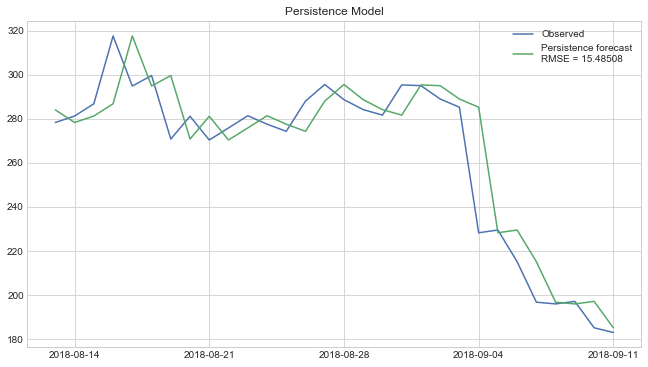

In [6]:
plt.figure(figsize=(11,6))
plt.title("Persistence Model")
plt.plot(
    df.index[-31:-1],
    df.eth_close[-31:-1],
    label="Observed",
    c=colors[0]
)
plt.plot(
    df.index[-31:-1],
    X_pred,
    label="Persistence forecast\nRMSE = {:.5f}".format(rmse_persist),
    c=colors[1]
)
plt.legend()
plt.show()

## Feature Engineering
### Create Dummies for Changepoints

In [7]:
import ruptures as rpt
cpts = rpt.Pelt(model="rbf").fit_predict(pd.DataFrame(df.eth_close), pen=20)
print(cpts)

[655, 855, 950, 1095, 1134]


In [8]:
breaks = cpts[:-1]
for i, point in enumerate(breaks):
    df["break_{}".format(i)] = 0
    df["break_{}".format(i)][point:] = 1

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


## LSTM RNN Time Series Only
- Predict last 30 days of eth close price

In [ ]:
# set time series data & target
#X = df.loc[:, df.columns.isin(["eth_close",
#                               "break_0", "break_1", "break_2", "break_3"])]
X = df.eth_close
y = df.shift(-1).eth_close
print(X.shape, y.shape)

In [ ]:
X_train, X_test = X[:-31], X[-31:-1]
y_train, y_test = y[:-31], y[-31:-1]
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

In [ ]:
# reshape and scale
X_train = np.array(X_train).reshape(-1,1)
X_test = np.array(X_test).reshape(-1,1)
y_train = np.array(y_train).reshape(-1,1)
y_test = np.array(y_test).reshape(-1,1)

#scaler = MinMaxScaler(feature_range=(0,1))

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
y_train = scaler.fit_transform(y_train)
y_test = scaler.fit_transform(y_test)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

In [ ]:
def prep_data(data, window_size = 1):
    data_reshaped = np.reshape(data, (data.shape[0], window_size, data.shape[1]))
    return data_reshaped

def fit_lstm(X_train, y_train):
    model = Sequential()
    model.add(LSTM(4, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss="mean_squared_error",optimizer="adam")
    model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1)
    return model

def validate(model, X, y):
    yhat = model.predict(X)
    yhat_invert = scaler.inverse_transform(yhat)
    y_orig = scaler.inverse_transform(y)
    rmse = np.sqrt(mean_squared_error(y_orig, yhat_invert))
    return (yhat_invert, y_orig, rmse)

In [ ]:
X_train = prep_data(X_train)
X_test = prep_data(X_test)

In [ ]:
# train model
lstm_ts = fit_lstm(X_train, y_train)

In [ ]:
# validate results
train_val = validate(lstm_ts, X_train, y_train)
test_val = validate(lstm_ts, X_test, y_test)

print("train rmse = {:.5f}".format(train_val[2]))
print("test rmse = {:.5f}".format(test_val[2]))

In [ ]:
plt.figure(figsize=(11,6))

# observed
plt.plot(X.index[-31:-1],
         test_val[1],
         label="observed",
         c=colors[0])
# persistence
plt.plot(
    df.index[-31:-1],
    X_pred,
    label="Persistence forecast\nRMSE = {:.5f}".format(rmse_persist),
    c=colors[1]
)
# predictions
plt.plot(X.index[-31:-1],
         test_val[0],
         label="test set predictions\nrmse = {:.5f}".format(test_val[2]),
         c=colors[2])
plt.legend()
plt.show()

## LSTM RNN w/ Exogenous Variables

In [ ]:
# set time series data & target
X = df
y = df.shift(-1).eth_close

X_train, X_test = X[:-31], X[-31:-1]
y_train, y_test = y[:-31], y[-31:-1]
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

In [ ]:
# reshape and scale
y_train = np.array(y_train).reshape(-1,1)
y_test = np.array(y_test).reshape(-1,1)

scaler = MinMaxScaler(feature_range=(0,1))

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
y_train = scaler.fit_transform(y_train)
y_test = scaler.fit_transform(y_test)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

In [ ]:
X_train = prep_data(X_train)
X_test = prep_data(X_test)
print(X_train.shape, X_test.shape)

In [ ]:
# train model
lstm_exog = fit_lstm(X_train, y_train)

In [ ]:
# validate results
trainx_val = validate(lstm_exog, X_train, y_train)
testx_val = validate(lstm_exog, X_test, y_test)

print("train rmse = {:.5f}".format(trainx_val[2]))
print("test rmse = {:.5f}".format(testx_val[2]))

In [ ]:
plt.figure(figsize=(11,6))

# observed
plt.plot(X.index[-31:-1],
         test_val[1],
         label="observed",
         c=colors[0])
# persistence
plt.plot(
    df.index[-31:-1],
    X_pred,
    label="Persistence forecast\nRMSE = {:.5f}".format(rmse_persist),
    c=colors[1]
)
# ts predictions
plt.plot(X.index[-31:-1],
         test_val[0],
         label="ts test set\nrmse = {:.5f}".format(test_val[2]),
         c=colors[2])
# exog predictions
plt.plot(X.index[-31:-1],
         testx_val[0],
         label="exog test set\nrmse = {:.5f}".format(testx_val[2]),
         c=colors[3])
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(11,6))

# observed
plt.plot(X.index[-31:-1],
         df.eth_close[-31:-1],
         label="observed",
         c=colors[0])
# ts predictions
plt.plot(X.index[-31:-1],
         test_val[0],
         label="ts test set\nrmse = {:.5f}".format(test_val[2]),
         c=colors[1])
# exog predictions
plt.plot(X.index[-31:-1],
         testx_val[0],
         label="exog test set\nrmse = {:.5f}".format(testx_val[2]),
         c=colors[2])
# persistence baseline
plt.plot(X.index[-31:-1],
         X_pred,
         label="persistence model\nrmse = {:.5f}".format(rmse),
         c=colors[3])
plt.legend()
plt.show()